# Odkrivanje skupin in izris kart dokumentov

Dimenzionalnost vektorskih predstavitev dokumentov lahko zmanjšamo na 2, kar nam omogoča prikaz dvodimenzionalne karte dokumentov, na kateri vsaka točka predstavlja dokument. Poleg tega lahko v dvodimenzionalnem prostoru odkrijemo skupine podobnih dokumentov in vsako skupino na karti obarvamo z različno barvo. To nam omogoča dober vpogled v celotno množico dokumentov.

Za začetek si spet preko API-ja pridobimo besedila zadnjih 100 predlogov vladi, ki vsebujejo vsaj 50 znakov ter iz datoteke preberemo fastText vektorje iz prejšnjega primera.

In [1]:
from textsemantics.server_api import ServerAPI
import numpy as np
from scipy.sparse import load_npz
import string
import nltk
nltk.download('stopwords', quiet=True)
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_SLOVENE

api = ServerAPI()
metadata = api.get_metadata('predlogi-vladi', sample_size=100, sampling_strategy='latest')

texts = api.get_texts(urls=metadata['text'])
texts = [text for text in texts if len(text) > 50]

def preprocess(corpus):
    stop_words = set(stopwords.words('slovene'))
    tokenizer = RegexpTokenizer("\w+")
    lemmatizer = Lemmatizer(dictionary=DICTIONARY_SLOVENE)
    
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]
        preprocessed.append(tokens)
        
    return preprocessed

tokens_list = preprocess(texts)

ft = np.load('data/ft.npy')
    

Nato dokumente vložimo v dvodimenzionalni prostor, poiščemo skupine ter vsako skupino opišemo s specifičnimi besedami na način podoben tistemu, ki je opisan v zvezku `04_01_specific_words_with_embeddings`.

Število skupin: 4, Število dokumentov, ki niso v skupinah: 50


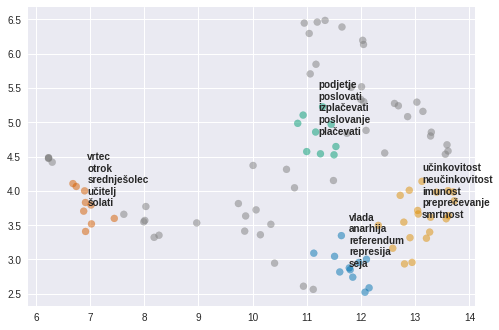

In [2]:
from umap import UMAP
from sklearn.cluster import DBSCAN
from utils.specific_words import prepare_data, find_cluster_words
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

umap = UMAP(n_neighbors=5, min_dist=0.0, metric='cosine', random_state=0).fit(ft)


dbscan = DBSCAN(min_samples=8).fit(umap.embedding_)
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
palette = sns.color_palette('colorblind', n_clusters)
print(f"Število skupin: {n_clusters}, Število dokumentov, ki niso v skupinah: {n_noise}")


doc_embs, words, word_embs, word2doc, doc2word = prepare_data(tokens_list)
cluster_describer = find_cluster_words(doc_embs, words, word_embs, dbscan.labels_)

cs = [palette[l] if l > -1 else (0.5, 0.5, 0.5) for l in dbscan.labels_]
plt.scatter(umap.embedding_[:, 0], umap.embedding_[:, 1], c=cs,
            alpha=0.5);

for cluster, words in cluster_describer.items():
    centroid = np.mean(umap.embedding_[np.where(labels == cluster)[0], :], axis=0)
    ann = "\n".join(cluster_describer[cluster][:5])
    plt.text(centroid[0], centroid[1], ann, fontdict={'fontweight': 'bold'})

Poglejmo si bolj podrobno, kateri dokumenti se nahajajo v vsaki izmed odkritih skupin. S tem se lahko prepričamo v smiselnost rezultatov.

In [3]:
from IPython.display import display, Markdown

mdstr = ''
for c in cluster_describer.keys():
    mdstr += f'\n# Skupina {c} ({", ".join(cluster_describer[c][:5])})'
    wh = np.where(labels == c)[0]
    for w in wh:
        mdstr += "\n - {}".format(texts[w].replace('\n', ''))
display(Markdown(mdstr))


# Skupina 0 (vlada, anarhija, referendum, represija, seja)
 - Ker je dosedanja vlada prepovedala referendume, predlagam, da se takoj uredi možnost sodelovanja vseh državljanov preko računalnika, s svojim digitalnim potrdilom.Vseh cca.1,5 milijona odraslih ljudi, bi morali sodelovati pri odločitvah vseh pomembnih zadev in ne le tista peščica v parlamentu.
 - Predlagam odstop celotne vlade RS, vključno z ministri in poslanci, ki nas imajo za norce in ustrahujejo narod in uvajajo ukrepe, ki škodijo. Dovolj je vse te represije in psihiranja, ustahovanja in laži in korupcije! Odstop vseh takoj!
 - Ker se po socialnih omrežjih širi vsak dan več laži, ki pozivajo k nespoštovanju ukrepov, o neobstoju epidemije, k nespoštovanju zakonov ipd, ljudje pa jim naivno verjamejo, predlagam, da se za določeno obdobje popolnoma ukine dostop do interneta, predvsem pa do Facebooka, Twitterja in kar je še podobnih orodij za širjenje teorij zarote.
 - Predlagam, da se evtanazija legalizira. Kdor želi po svoji volji po poti evtanazije, naj se mu to omogoči.
 - Predlog da državljani Bosne in Hrecegovine z stalnim bivališčem v Sloveniji lahko kupijo nektetnine(hiso,stanovanje) mislim da Slovenija nič ne more izgubit s tem..
 - Predlagam vladi, da nemudoma prepove prodajo energijskih pijač mladoletnim osebam. Ob prodaji morajo prodajalcu pokazati oseben dokument. Od vlade pričakujemo resen ukrep, ne samo prazne obljube NIJZ-a in suhoparne članke s statistikami in posledicah, od vlade pa dejansko nobenega ukrepa. Pri nas ni nikakršne omejitve, v Veliki Britaniji je prepoved prodaje pod 16 let, Litva nad 18 let, Nemčija je prav tako prepovedala prodajo v nekaterih državah. 
 - Vladi predlagamo ,da na seznam terorističnih organizacij uvrsti skupino ANTIFA in ANONYMUS Slovenija, saj njihova dejanja kažejo na rušenje ustavnega reda Republike Slovenije, pozivanje k nasilju, dejanja agresije in uporabo vseh bojnih sredstev za dosego anarhije. Vlada naj obe skupini prepove in uvede visoke denarne in zaporne kazni za organizatorje ,vodje in člane.
 - V Avstriji bodo po islamističnem terorističnem napadu na Dunaju zaprli radikalne mošeje v državi. Tako bodo zaprli mošejo, ki jo je obiskoval napadalec, zaprli bodo tudi islamski center, ki ga je obiskoval 20-letnik. Odločitev so sprejeli po sestanku s predsednikom Islamske verske skupnosti v državi Ümitom Vuralom, poroča časopis Krone Zeitung, ki na svoji spletni strani dodaja, da naj bi mošejam odvzeli pravni status, prav tako naj bi razpustili tovrstna združenja.V smislu specialne prevencije predlagam, da se zapre ljubljanska mošeja in islamski center ter se ji/mu odvzame pravni status.
 - Pozdravljeni,skoraj dve leti je že minilo, od kar je Slovenija ne upoštevajoč volje državljank in državljanov, podpisala Globalni dogovor ZN za varne in zakonite migracije. Kot se je s strani vlade takrat poudarjalo, dogovor pravno ni zavezujoč, kar je po svoje res. Po drugi strani pa se od držav, ki so dokument podpisale, nekako pričakuje, da postopoma prilagaja nacionalno zakonodajo, v smeri migracijam bolj prijazne politike. Težava pri tem je, da dokument nikjer strogo ne loči ilegalnih na eni in legalnih migracij na drugi strani.Situacija po svetu je vsem dobro znana. Soočamo se z zdravstveno krizo, kot je še nihče izmed nami ni doživel. Gre za izjemen dogodek, ki bo imel neslutene posledice. Države so bile primorane vzeti stvari ‘v svoje roke’, tako glede oblikovanja varnostnih in preventivnih ukrepov, kot tudi pri nakupu medicinske opreme in strategiji pri odpravljanju posledic pandemije. Kako naj ob vsem tem lahko zaupamo globalnim dogovorom, ko pa niti institucije, ki smo jim resnično pravno zavezani (npr. EU), niso bile sposobne ukrepati.Po vsem, kar smo v teh mesecih doživeli, se mi zdi prav, da ponovno odprem to vprašanje. Dejstvo je, da Globalni dogovor ZN pač ni predvidel te krize. Se potemtakem zdi podpis na tem dogovoru sploh smiseln? Skrbi me, ker omenjeni dokument niso podpisale tri naše sosednje države. Če pustimo ob strani Madžarsko in njene nacionalne interese, sta tu Avstrija in pozor Italija (!), ki je, kot vsi dobro vemo, ena glavnih vstopnih točk. To pa, vsaj če pomislimo na geopolitčni položaj Slovenije, nikakor ni dobro. Mislim da je napočil pravi trenutek, da se razpiše posvetovalni referendum in naj se ljudstvo odloči. Za konec še provokativno vprašanje. So migracije človekova pravica?PS. Kot lahko vidite, je naše gibanje omejeno znotraj občin. Mi to spoštujemo!
 - Na volilnem seznamu označiš eno OSEBO, ki je nikakor NOČEŠ, ne glede na njeno strankarsko pripadnost. Potem pa prvih deset, ki dobijo največ 'minusov', v obdobju naslednjega mandata odstraniti z VSEH javnih funkcij, niti tajnik balinarskega društva ne sme biti več! Niti na vodilnem mestu v javni službi/podjetju. (V zasebne se pač nebi vtikal.)Tako bi se znebili največjih negativcev, ki jih že vsi zaničujemo in sovražimo, pa tudi same stranke bi se znebile ljudi, ki jim v resnici delajo škodo / odvračajo volilce. Lopovi bi vsaj malo pazili, kaj počnejo (in jim sodniki zdaj zastarajo postopek, če že ne kar ukažejo uničiti dokaze ...) oziroma malo manj direktno lagali in javno goljufali.
 - Predlagam da nemudoma prepove virusu kakršnje koli udejstvovanje v državi Sloveniji in tudi drugje po svetu. Preprosto ne razumem kako se države ino njih vlade še niso domislile tega in virusa preprosto prepovedale in fertik. Da ne omenjam tega, da si celo dovoli prehajati meje brez ustreznega potnega lista, pa to je ja mednarodni kriminalc. Zdaj pa res, nemudoma sklenite izredno sejo in sprejmite zakon, potem pa so na vrsti mediji, da raztrobijo naokol novico, da toti kriminalc nebo še. kje trdil da ni vedel. Obvezno gostovanje v Tarći ter 24kur in Luni na kanalu B
# Skupina 1 (učinkovitost, neučinkovitost, imunost, preprečevanje, smrtnost)
 - Pozdravljeni,v času katastrofalnega naraščanja okužb v državi in s ciljem preprečevanja dodatnih rizičnih stikov predlagam, da v kolikor vodstvo Vrhovnega sodišča RS očitno ne ukrepa v skladu z epidemiološkim stanjem v državi, da Vlada sama presodi in sprejme ukrepe, ki bi zaustavili tek rokov in izvajanje narokov v vseh sodnih zadevah nenujne narave.Trenutno se namreč z nerazumljivim odlašanjem in očitnim dokazovanjem principov s strani vodstva Vrhovnega sodišča RS, pa tudi brezbrižnosti upravljavcev večjih odvetniških družb, ki iz naslonjačev pošiljajo v ogenj svoje "manj pomembne" podrejene, kaže razkorak v primerjavi z ukrepi na ostalih področjih kot so npr. neizvajanje nenujnih zdravstvenih storitev, ki pa so z vidika reševanja človekovega zdravja zagotovo pomembnejše od izvajanja pravosodnih organov v t.i. nenujnih sodnih zadevah. V slednjih se namreč udeležence sodnih postopkov (stranke, pooblaščene odvetnike, izvedence, sodno osebje itd.) celo v današnjih razmerah sili v interakcijo in tudi fizične stike, ki so sicer potrebni, da se zadosti izvedbi prekluzivnih sodnih rokov in narokov, medtem ko pa z vidika epidemiološke situacije v državi predstavljajo nezaželjenjo ustvarjanje stikov in nenazadnje v teh okoliščinah tudi neustrezen pritisk na same stranke, ki v postopkih pred sodiščih sicer iščejo svojo pravico, ne pa tudi izgubo zdravja.Hvala za pozornost in obravnavo ter skrb za zdravja in življenja ljudi ter nasplošno dobrobit državljanov.Lepo vas pozdravljam v želji, da se stanje v državi glede epidemiološkega stanja čimprej obrne na bolje.S spoštovanjem,Janez
 - Osredotočiti bi se moramo na preventivo. Zagotoviti zadostno količino vitamina C in D in ga brezplačno (!) nameniti državljanom. Dodatno še cink in druge naravnih snovi, ki lahko dejansko pomagajo telesu. In zdravju.Vlada naj takoj preveri spiske glavnih onesnaževalcev zraka in vod in jim najmanj omeji, ob stopnjevanju virusne krize pa prepove delovanje. Prav onesnaženost zraka je že bila znanstveno izpostavljena kot velik problem za širjenje virusa. Namesto milijonov za ljudi, ki jih aktualna politika napačno zapira domov in jim uničuje posle, bi sredstva namenili za nujno potrebno prestrukturiranje onesnaževalcev, kar bi tako ali tako morali narediti, če želimo samooskrbno Slovenijo, zgolj v pomoč nam je t.i. virusna kriza.K sodelovanju naj Vlada nemudoma povabi strokovnjake na področju komplemetnarne in integrativne medicine. Če kaj drži, je v času t.i. virusne krize ključni problem alopatske medicine, da ne zna celostno oceniti in detektirati izvorov nezdravja v telesu. Več kot jasno namreč je, da izključno virus ni vzrok smrtnosti, lahko pa je virus ali virusi v povezavi z drugimi bolezenskimi stanji. Tu nujno potrebujemo celostni pristop prej navedenih. Ki to znanje imajo. In ni jih malo!Tako je potrebno ukiniti bi vse programe obveznih cepljenj. Saj lahko prav cepljenje proti gripi (še posebej v jesensko-zimskem letnem času) vpliva s padcem imunosti tudi na dovzetnost za virus(e)! Za navedeno že obstajajo znanstvene študije in objave o morebitnem dogajanju v Bergamu glede na brezplačno cepljenje proti gripi konec leta 2019 za vse starejše od 65 let.Bistveno se morate posvetiti dvigovanju morale in optimizma državljanov. Z ves čas odprtimi vrtci, šolami in fakultetami. Brez zlorabe digitalne tehnologije, ki lahko negativno vpliva na razvoj predvsem otrok. In poudarku na vzgoji otrok z znanji preventive. In samooskrbe. Pomenu svežega zraka. Pitne vode. In narave.Brez zapiranj, omejitev in z načrtnimi sporočili o preventivi, pomenu gibanja na svežem zraku, pomenu zdrave hrane, izogibanja alkoholu in hkrati tobačnim izdelkom, ki tako ali drugače vplivajo na dihalne organe.V vrtcih, šolah, bolnicah, domovih za starejše in vseh javnih ustanovah je potrebno nemudoma prepovedati uporabo wifi tehnologije in ozaveščanje glede uporabe mobilnih podatkov. Takojšnja prekinitev postopkov glede nadaljevanja širitev brezžičnih telekomunikacijskih tehnologij (kot je 5g in podobno) na osnovi načela previdnosti in jasno navodilo telekomunikacijskih podjetjem, da aktivnosti usmerijo v optične povezave. Javne ozaveščevalne kampanje o škodljvosti elektromagnetnih sevanj brezžičnih tehnologij in predvsem o varni uporabi tehnologije. Tudi o varni uporabi mobilnih telefonov in tablic s priključitvijo na optično omrežje.Takojšnja prepoved proizvodnje, prodaje in uporabe strupov kot je glifosat. Načrtne subvencije za saooskrbo z ekološko pridelano hrano. Postopno prestrukruriranje od odvisnosti od uvoza (nezdrave) hrane.O vseh ukrepih v državi bi naj končno soodločajo strokovnjaki, ki nimajo konflikta interesov na področju medicine/imunologije, varstva okolja, gospodarstva, davkov in podobno. Nobena stroka ne sme prevladovati, išče naj se konsenz ukrepov. Policija in vojska sta lahko izključna podpora ljudem in nikakor ukrepom politike. In interesnih skupin. In skupin pritiska.Ni res, da se ne da. Ni res, da nimamo alternativ. Ni res, da nimamo izbire.
 - Pozdravljeni!Zadnje dni prihajajo po medijih do nas volivcev informacije, da je eden od naslednjih možnih ukrepov vlade z namenom zajezitve širjenja okužb s COVID 19 tudi ta, da bi nam omejili gibanje zgolj na naša stanovanja. Glede na to, da določen del prebivalstva svojega dela ne more opravljati na daljavo (zaposleni v zdravstvu) in bo še vedno obstajala možnost širjenja okužbe v delovnih okoljih, ter da za zdravje potrebujemo svež zrak, sonce in gibanje, podajam mnenje, da je tak ukrep nesmiseln.Moj predlog vladi je, da takega ukrepa ne sprejme. Barbara Prosen, dr. med., spec. anesteziologije, reanimatologije in perioperativne intenzivne medicinezaposlena v SB Novo mesto
 - Dokazano je da je smrtnost v primeru covid 19 le za 0.04 % večja kot pri gripi. To kaže na nesmiselnost ukrepov. Vladi predlagam da odstrani vse ukrepe zaradi njihove nesmiselnosti upoštevajo pa naj se prostovoljno. Upoštevajo naj jih le tisti ki si to želijo ker so v rizični skupini in je njihov strah pred okužbo utemeljen.
 - Dandanes imajo "influencerji" in javne osebe skorajda večji vpliv kot standardni mediji, zato predlagam, da se z globo kaznuje osebe, ki širijo lažne novice in s tem ogrožajo celotno prebivalstvo. Kdor je javno znan ali dosega veliko število delitev (npr. 50
 - Ponoči v času policijske ure gori javna razsvetljava, ki pa glede na situacijo ni najbolj energetsko varčna in okolju prijazna. Izklop bi tudi zmanjšal stroške državljanov in države same.
 - Glede na to, da so se odprle knjižnice, predlagam, seveda ob upoštevanju vseh zaščitnih ukrepov proti širjenju virusa, kot je umivanje in razkuževanje rok in nošenje mask v zaprtih prostorih, da se po hitrem postopku odprejo tudi knjigarne, galerije in muzeji. Glede na frekvenco obiska tudi sicer ti prostori nikakor niso vir širjenja virusa, so pa izjemno pomembni za duševno zdravje državljank in državljanov Slovenije. Kultura je bila vedno gonilna sila obstoja slovenskega naroda. Obenem pa so z zaprtjem kulturnih ustanov mnogi, ki že sicer spadajo v ranljivo skupino glede zaposlovanja, izgubili še to možnost dela in vira dohodka.
 - Vladi predlagam, da skupaj z zdravstveno stroko opravi širšo razpravo o tem, kako bi preprečili, da ljudje zaradi strdkov žilah tudi umrejo. Obstaja zdravilo, ki to preprečuje, saj REČI kri bi lahko vsem tistim nad določeno starostjo, ki bi jo na podlagi statistike določila stroka dali zdravilo Aspirin protect 100 mg tablete. Tako bi se lahko izognili marsikateri smrti.
 - Vladi predlagam spremembo oz dopolnitev Zakona o duševnem zdravju, ki jih čaka že dalj časa na mizi. Predlagam slednje:1. Prepoved privezovanja s pasovi v psihiatričnih bolnišnicah, poseči po manj travmatičnem postopku v primeru izgreda ob sprejemu v psihiatrično bolnišnico, prepoved privezovanja s pasovi v primeru, ko pacient odklanja zdravila itd2. Sprememba zakona o duševnem zdravju ob sprejemu pacienta, ki v zdravljenje ne privoli in je sprejet na zaprti oddelek psihiatrične bolnišnice (manj agresivni načini sprejema na zaprti oddelek v spremstvu svojca oz osebe, ki ji pacient zaupa itd)3.Naj bo ob sprejemu pacienta v bolnišnico prisotno sodišče še isti dan preden se pacientu predpišejo zdravila, kot so Haldol, Abilify, Torendo, Moditen in ostali antipsihotiki, ki dokazano spremenijo obnašanje pacienta. Pod vplivom Haldola recimo, ne zmoreš govoriti, hoditi, misliti, nisi zmožen opraviti najnujnejših reči kaj šele, da bi se zagovarjal pred sodiščem pod vplivom antipsihotikov. Sodišče se namreč dodeli, ko pacient ne privoli na zdravljenje na zaprtem oddelku. Sodišče pristopi k pacientu šele 3,4 dan po sprejemu na zaprti oddelek. V tem času je pacient že hudo pod vplivom psihiatričnih zdravil. Ob sprejemu v psihiatrično bolnišnico namreč velja, da posegajo po bolj agresivnem zdravljenju in predozirajo marsikaterega pacienta. Zdravstveno stanje pacienta se tako še poslabša pod vplivom antipsihotikov. Nemogoče se je zagovarjat pred sodiščem v takem stanju. Antipsihotiki dokazano primejo že prvi dan ob njihovi uvedbi ne šele čez nekaj tednov, kot to piše v strokovni literaturi oz v navodilih za uporabo. Stranske učinke zdravil lahko občutiš že takoj po njihovem zaužitju. Verjetno je odvisno od primera do primera (koliko si občutljiv na kemijo itd)...4. V Zakon o duševnem zdravju naj se doda točka, ki zapoveduje nujnost bivanja na svežem zraku za paciente, ki so na varovanem oddelku psihiatrične bolnišnice. Sedaj je to dobra volja zaposlenih v psihiatrični bolnišnici, da se jih pelje dnevno ven na zrak.5. Zakon o duševnem zdravju naj bo vodilo vseh psihiatričnih bolnišnic po Sloveniji. V zakonu naj se dodajo točke o uporabi telefonov, kadilnic, jedilnic, psihoterapij, terapevtski oddelki ( sedaj so pacienti razdeljeni na paciente, ki bolehajo za depresijo in paciente, ki imajo psihotične znake bolezni), pacienti s psihozami ne pridejo do psihologov, zdravijo se izključno z zdravili, v zakonu naj se točno določi postopek odpusta iz psihiatrične bolnišnice v za pacienta varno okolje (tako bo manj samomorov) in še in še... Hišnega reda tako ne bi potrebovali, če bi bil zakon o duševnem zdravju širše in podrobneje napisan oz sestavljen. S tem ne bi prihajalo do dvomov, naj si bo pri zaposlenih pa tudi pri pacientih, ki so v stanju zakon preučiti. Pacienti so zelo slabo seznanjeni s svojimi pravicami, kar se mora spremeniti. Z vsemi svojimi pravicami bi morali biti seznanjeni takoj ob sprejemu, če le ni njihovo stanje oz zdravje v tako slabem stanju, da to ni moč narediti. Odgovornost in odločitev naj sprejme sodišče v dogovoru s psihiatrom, ki pacienta sprejme v sprejemni ambulanti.6. Psihiatrične bolnišnice po Sloveniji so potrebne prenove. Bivanje v njih ni nič terapevtsko. Vse skupaj spominja na veliko revščino kar se sob in kopalnic tiče. Govorim za PB Idrija, kjer sem bila že večkrat hospitalizirana (diagnoza - F25.2, zmešan tip). Ob tem bi pohvalila neverjetno človečnost medicinskih sester in tehnikov, ki za drobiž puščajo tam svoje zdravje. Psihiatri so večinoma nedostopni (ne vsi) ampak to v Sloveniji ni nič novega. Upam, da se najde kje, kdaj žvižgač, ki bo spregovoril o tem, kar se dogaja po slovenskih psihiatričnih bolnišnicah, ki bo spregovoril o nevarnosti uporabe psihiatričnih zdravil itd...7. Svež veter je bolj zdravilen kot tisoč odmerkov zdravila. Asklepij8., 9., 10., 11., ... Drugič
 - To da ima vsaka bolnišnica drugačne cene istih testov in da se s temi testi dela posel-profit, meče ne samo senco dvoma na interese izza testov ampak močno vzpodbuja razne debate o verodostojnosti teh poslov.Vlada naj zagotovi enotno ceno teh testov povsod v državi in le ta naj bo primerljiva z cenami v drugih EU državah. To da je cena v Italiji 3 evre, Avstriji 5 evrov v bolnišnici Celje 7 evrov, UKC Maribor 35 evrov in Šempeter 11 evrov močno smrdi po goljufanju in prisiljenih odvzemih brisov v imenu biznisa.Enak test nekaj kilometrov dlje ne more stati 10 kratnik sosedovega.
 - Vladi predlagam, da razmisli o dodatni izjemi, za katere je prehajanje med občinami dovoljeno, tudi za obisk slovenskih hribov in gora vsaj za člane Planinske zveze Slovenije (PZS).Nekatere občine nimajo primernih hribov, hoja v hribe pa je zelo zdrava rekreacija, ki pozitivno vpliva tako na naše telo, psihično počutje in imunski sistem. Stiki med ljudmi so minimalni. Dokaz pri kontroli pa je planinska izkaznica.
 - Predlagam hitre teste za VSE državljane.S tem bi tudi tako imenovani prenašalci ostali doma za določenih 10, 14 dni in stanje v zvezi z Covid19 bi se moralo po tem času popolnoma izboljšati.Pripomoglo bi k hitrejši normalizaciji stanja za vse državljane. Torej vsi pozitivni ostanejo doma, med tem, ko bi ostali naprej izvajali rutino. Predlog za hitre teste za vse nad 15let.Denar za vse hitre teste naj seveda gre iz proračuna države, saj bi na koncu tudi država z gospodarstvom dobro odnesla od omenjenega predloga.
 - Prometnemu ministru predlagam odpravo kazenskih točk (sedaj je odpis le-teh v dveh letih).Tako ali tako redarstvo in policija postavljata radarje na mestih samo zaradi prihodka v državni proračun, ki pa nima nobene zveze z varnostjo prometa.Za težje prometne prekrške (posledica bolniški stalež) šest mesečni odvzem in možnost ponovnega izpita, za povzročitev invalidnosti ali smrti pa odvzem prometnega dovoljenja in kazensko odgovornost  
 - Več kot očitno dosedanji ukrepi ne dosegajo rezultatov, ki bi si jih vsi želeli. Da bi se ustavilo povečevanje zdravstvene in zmanjšalo velikost ekonomske krize predlagam popolno zaprtje, kot smo ga imeli spomladi. Le tako se bo lahko življenje vseh čim prej vrnilo v kolikor toliko normalno stanje saj med polovičnimi ukrepi trpljenje vseh že tako močno prizadetih strok med polovičnimi ukrepi samo podaljšujemo.
 - Predlagam, da se javnost preko medijev redno (dnevno) opozarja in ozavešča o nujnosti pravilnega in doslednega nošenja zaščitnih mask ter da se redno izvajata tako opozarjanje, kot učinkovit nadzor nad spoštovanjem tega ukrepa, ki je po mnenju domače in tuje stroke eden od treh ključnih za zajezitev epidemije COVID 19.
 - Predlagam ponovno zamrznitev ocenjevanja in izplačevanja redne delovne uspešnosti v javnem sektorju (uspešnost se je po letu 2009 pričela letos ponovno izplačevati), ker pomeni dodatno obremenitev za javno blagajno, javne uslužbence pa ne motivira, temveč ravno nasprotno. Način ocenjevanja in izplačevanja, kot je trenutno zastavljen, povzroča pri javnih uslužbencih veliko slabe volje in nezadovoljstva.
 - Glede na to, da se že pojavljajo mutacije visura pri kunah in prenos nazaj na človeka, kar lahko pomeni zmanjšano učinkovitost cepiv ali celo njihovo neučinkovitost v skrajnem primeru, medtem ko naj bi cepivo, ki ga razvija Kemijski institut zaradi drugačnega principa delovanja bilo učinkovito kljub takim mutacijam, predlagam, da se podpre (finančno in na drug način) nadaljnji razvoj (in testiranja) tega cepiva.
 - Ob prvem valu je bil dodatek za delo med EPIDEMIOLOGIJE 19 200€. Med drugim valom pa tvegamo glave za minimalne plače (brez dodatkov).Varnostno osebje naj dobi 200€ dodatka do konca epidemije COVID 19 in povrnjene stroške do pravnega vala COVID 19.
 - Če so omejitve glede bivših zapornikov v smislu prepovedi zaposlovanja in uživalcev alkohola in drog naj se prepove tudi kajenje na delovnem mestu in nova zaposlovanja.Nikotin je droga in osebe, ki uživajo droge (če imamo enaka merila za vse) nimajo kaj iskati v ožji državni upravi (ministrstva, direktorati, upravne enote, zavodi, podjetja v državni lasti itd.).Sprostilo se bo veliko delovnih mest za osebe, ki jih Ustava RS in zakoni zapovedujejo, kot primerne za opravljanje tovrstnih del.Enaka merila za vse, ali pa nič.
 - V skladu s švedskim modelom zagotovimo dovoljšen nivo D vitamina populaciji. Razlog:1. 80% bolnikov v bolnišnicah zaradi COVID-19 ima znižan nivo D vitamina.2. Pri okužbi z COVID-19 ustrezen nivo D vitamina zniža verjetnost smrtnega izida za 89%3. Ustrezen nivo D vitamina lajša simptome, potek bolezni in zmanjšuje verjetnost trajnih posledic pri prebolevanju okužbe z COVID-19 Navkljub ne-restriktivnemu pristopu ima Švedska eno izmed nižjih nivojev smrtnosti in kužnosti v Evropi.Ta dognanja so opazili tudi v Veliki Britaniji, kjer bodo sedaj začeli razdeljevati D vitamin splošni populaciji. Gradivo:www.sciencedirect.com/science/article/pii/S096007602030296Xscitechdaily.com/over-80-of-hospitalized-covid-19-patients-have-vitami...
# Skupina 2 (podjetje, poslovati, izplačevati, poslovanje, plačevati)
 - Menim, da bi morali v Sloveniji tako kot obdavčimo gospodinjstva in podjetja obdavčiti tudi verske institucije. Tako bi obdavčili vse verske obrede (maše, poroke, pogrebe). Če lahko Cerkev kupuje luksuzne nepremičnine v evropskih mestih, potem lahko tudi plačuje davke. S tem bi v državno blagajno priteklo več denarja, ki bi nam v teh časih še kako prav prišel.
 - V letošnjem letu se mnogi posamezniki kot tudi podjetja srečujejo s težavami povezanimi s COVID 19. Sam se bom osredotočil na problematiko subvencij - pomoči gospodarstvu. Zavedam se, da je v času v katerem se nahajamo potrebno pomagati gospodarstvu po najboljših močeh in zmožnostih. V preteklih mesecih je bil porabljen velik del sredstev vlade za ohranjanje delovnih mest in delovanja gospodarstva vsaj v nekih minimalnih okvirjih. Večji del podjetij in s.p.- jev je upravičeno do nadomestil a vem tudi za kar nekaj takih, ki v času krize ne iščejo rešitev vendar so zgolj osredotočena na pomoč vlade in zavestno zapirajo svoje obrate. So primeri, ko lastnik-ca obrata zapre svoja vrata in odpotuje na Kanarske na oddih ker računa na pomoč vlade. Zavedam se, da takih pijavk država ne more odkrivati, ker ima glede na razmere več ostalega dela a glede na omenjeno menim, da bi morala vlada na drugi strani razmisliti o spodbudah podjetjem, ki pa v času krize poslujejo zelo dobro in prispevajo ne mali delež k polnjenju državnih blagajn s plačili prispevkov. Moj predlog je, da bi takim podjetjem vlada znižala ( 15%) obdačitev ustvarjenega dobička za poslovno leto 2020 in tako nagradila podjetja, ki kljub krizi poslujejo in držijo gospodarstvo nad vodo. 
 - Predlagam, da se s.p.-jem omogoči mirovanje delovanja, namesto da se zapirajo, po krizi pa se bodo najverjetneje ponovno odpirali.
 - Pozdravljeni, Vlada je 26.10. obravnavala in vložila januarja predlagano spremembo, kjer uvaja spremembe na področju obdavčitve vozil.Ker ni videti nobenih sprememb, je sklepati, da bodo po prvotnem predlogu dražja praktično vsa vozila. Razen par zelo luksuznih. Vnovič pozivam, da se ukinejo oz. vsaj korenito spremenijo trenutni davki za vozila. To sta DMV (davek na motorna vozila) in davek na luksuz.Smo v težkih časih, države znižujejo davke, naša država pa ukinja davek na luksuz na račun podražitve VSEH vozil To je zelo neposrečena rešitev, saj bodo vsakodnevna vozila, ki jih družine množično vsakodnevno uporabljajo, dražja za 200-300%, luksuzna vozila pa bodo cenejša za par deset tisoč evrov, a še vedno ne dovolj, da bi se jih splačalo registrirati pri nas. Obremenili bi torej vse sloje - razen seveda najpremožnejših. Za primer, če je davek na motorno vozilo za družinski avto tipa Golf ali Passat zdaj znašal 100 ali 200 €, bi po novem ta znesek znašal med 500 in 800 €. Po drugi strani pa bi nek drag mercedes bil cenejši za 50000 €. V teh časih je to popolnoma neproduktivna sprememba. Podražili bi torej najbolj prodajana vozila. Zakaj preprosto ne ukiniti vsega skupaj ali pa vsaj zadevo zastaviti bolj prijazno? Neki članek v enem izmed dnevnih časopisov je omenjal par evrov višji cestni sklad za vse, kar bi pomenilo iste prilive, s čimer bi nakup bil lažji čisto za vse. Tudi za najdražja vozila, ki jih po tem ne bi bilo smiselno registrirati drugje. Dajmo malo razmišljati praktično in logično, visoke dajatve pomenijo padec kupne moči, tega si pa ne želimo. Sploh pa ne v teh časih, ko je gospodarstvo osiromašeno. Lep pozdrav vsem!
 - Spoštovani.Predlagam, da se Rusiji (Rosatom) pošlje povpraševanja za izgradnjo JEK 2 pri Krškem.Za izgradnjo rektorja tipa VVER-TOI ali VVER-1200.Predlagam, da "kredit" za izgradnjo in predajo elektrarne nam prevzamejo rusi.Za kar bi mi izplačevali kredit.Verjamem, da bi s dovolj dobrim pogajanjem to mogoče dosegli.Lep pozdrav.
 - Predlagam da se turistični boni podaljšajo v leto 2021 saj jih velika večina ni mogla koristit zaradi epidemije,prezasedenosti kapicitet bolezni..
 - Kar nekaj podjetij se registrira in zapre. Ni pa verjetno posebno obvezno da mora podjetje po zaprtju podjetja tudi odstraniti reklamne in usmerjevalne table. Meni osebno je to dokaj moteče in šlampasto. Dobro bi bilo da se to zakonsko uredi in pooblasti občinske redarje da bi bili pozorni tudi na te stvari. Precej je takih tabel od podjetij katera že leta ne poslujejo več. Mogoče bi bilo dobro da se vsaka reklama in usmerjevalna tabla zabeleži v nekakšen sistem, in preden lahko lastnik podjetje zapre te reklame odstrani da se zaprtje podjetja lahko zaključi.
 - Do sredstev bodo upravičena mikro, mala in srednje velika podjetja iz določenih dejavnosti.Eden izmed pogojev je tud,i da so imela v povprečju minimalno 4 zaposlene v dejavnostih I 56.101, N 79.110, N 79.120, N 82.300 ter v povprečju minimalno 2 zaposlena v dejavnostih R 90.010 in R 90.020. DISKRIMINATORNO, NEENAKOPRAVNO ... zakaj kriterij 4 zaposleni v določenih dejavnostih?Zakaj s samo 2 zaposlenima v dejavnosti turističnih agencij nismo upravičeni po tem razpisu ?ali pri 2 zaposlenih so stroški po zaposlenem manjši kakor pri 4 ?NASPROTNO : pri 2 zaposlenih do večji po zaposlenem kakor pri 4. PROSIM ODGOVOR ZAKAJ SMO Z MANJ KOT 4 ZAPOSLENIMI IZVZETI ????????? 
 - Vse gospodarske družbe in podjetnike, ki ne poslujejo (so zaprte) zaradi Covid zakonodaje je potrebno zakonsko oprostiti plačevanja akontacij davka od dohodov pravnih oseb, oz. akontacij dohodnine za samozaposlene, v obdobju zakonskega zaprtja.
# Skupina 3 (vrtec, otrok, srednješolec, učitelj, šolati)
 - Pozdravljeni, kdaj boste dovolili registritanim športnikom, da se vrnejo na treninge? Gre za srednješolce, ki po starosti še niso člani, a jim bo počasi zmanjkalo volje, saj zaradi prekinitev nikakor ne pridejo do željene forme in s tem rezultatov...Športen pozdrav Anita Z.
 - Predlagam, da bi bili učenci v šoli, v mehurčku razreda, in učitelji, ki so doma zaradi izolacije ali karantene, pa na daljavo povezani z razredom. Seveda bi bilo dobro, da bi jih kontroliral kakšen prostovoljec, saj sicer ne bi bilo učinka (miru) z učenjem.Lep pozdrav.Ava Rajh
 - Otroci v prvih treh razredih osnovne šole se ne morejo šolati na daljavo, ne da bi starši pri tem sodelovali. Številni starši smo samozaposleni in si ne moremo vzeti dopusta, ne da bi pri tem utrpeli izpad dohodka, poleg tega imamo projekte, ki jih ne moremo kar odpovedati, ker bomo izgubili stranke in s tem dolgoročni vir dela in prihodkov.V prvem valu je bil način poučevanja prepuščen posameznim učiteljem in smo bili preuščeni sami sebi. Torej smo opravljali svoje delo in še delo učitelja. Po dveh mesecih smo bili starši izčrpani.Tudi če šola zagotovi pouk po zoomu, lahko to traja največ nekaj ur na dan, saj za majhne otroke ni primerno niti zdravo, da sedijo za računalniškimi ekrani ves dan. To pomeni, da je treba v preostalem delovnem času poskrbeti za varstvo, ki ga mnogi nimamo. Mnogi starši so tudi samohranilci, mnogi imajo po več otrok, ki so vsi v osnovni šoli. Mislim, da to, da otroci ostanejo doma, ni vzdržno.Če ne gre drugače, lahko tudi prepustite ravnateljem v posameznih občinah, da se glede na epidemiološko sliko v tisti občini odločijo, ali naj bo šola odprta ali ne in za katere razrede. 
 - Nerazumno je, da ostajajo šole zaprte, saj majhni otroci ne morejo biti sami, niti se ne morejo sami učiti. Ali sploh kdo pomisli na starše, ki morajo delati, a nimajo kam z otroki ( niso vsi v službah, kjer lahko kar ostanejo doma). Marsikdo je porabil še zadnji dopust v upanju, da se bo ta norija končala. Na robu obupa so ljudje, ki nimajo sredstev za preživetje, ki nimajo možnosti za učenje svojih otrok. Vse pridobljene pravice otrok so kar na hitro poteptane. Le zakaj smo za talce vzeli otroke, če vemo, da nevarnost preži na starejše, ki pa jih sedaj itak brez problema porivamo k otrokom kjer je to le možno. Koga pravzaprav ščitimo, vse bolj se zdi, da nikogar.Učitelji dobijo 100% plačo, da razpošljejo učne liste s pomočjo katerih potem starši /stari starši učijo otroke. Vsa skrb za šolanje je preložena iz učiteljev na starše, ali pa sploh na nikogar,Nekateri otroci so se prvič srečali s šolo, nekateri še brati ne znajo, če pa že, bodo itak vse pozabili, nekateri so v višjih razredih, a brez pomoči ne bodo zmogli. Kakšna katastrofa za njihovo prihodnost. Ne poveličujte šole na daljavo, ne sprenevedajte se, kako je vse v redu, ker ni. Kdor ima otroke in mu je zanje mar ve, kako to izgleda in, da je hvaljenje tega zgolj metanje peska v oči. Oglasijo se strokovnjaki, psihologi, a jih nihče ne posluša, še manj sliši.Pametne države niso zaprle šol, naša pa najbolj zapira ravno to, kar je res nujno. Ogromno je izjem, ljudje se sprehajajo tudi čez mejo, seveda če spadajo med priviligirane. Če bi res želeli ukrepati, bi morali ukrepi veljati za vse - tako pa....Kdor je situiran mu tudi šolanje otrok ni problem, kdor pa se bori za preživetje bo obupal in ubogi ti otroci, ki pa jih ni malo. Samo žal ubogih se niti ne vidi niti ne sliši.Sem starejša generacija in nočem več slišati, da ste solidarni s starejšimi, saj smo mi zdaj, če le zmoremo, v prvih "bojnih" vrstah. Virus bo odšel strašne posledice pa bodo ostale. Nasilje se največkrat rodi iz obupa, pa tudi iz neznanja in brezdelja. Otroci se morajo z nečim zaposliti, s počitnicami in šolanjem na daljavo zagotovo ne. Preveč imajo časa za vse neumnosti, iz dolgočasja pa nekaj pač morajo početi in to zagotovo ne samo pametne stvari. Zato ne jemljimo izobrazbe mladim, saj s tem, ko niso v šoli, zagotovo niso vedno v dobrem , še manj pa v varnem okolju.Sicer pa kaže da šole in učiteljev pravzaprav niti ne bomo več potrebovali, saj so vendar vsi starši zmožni spremljati učni proces in razložiti otrokom vse, kar je potrebno. Super, koliko bi lahko država prihranila!!!
 - Zanima me, zakaj so lahko odprti zavodi za otroke/mladostnike/odrasle s PP(posebnimi potrebami) in ne razvojni oddelki v vrtcih? Otroci, ki obiskujejo razvojni oddelek so v letih kjer je lahko največji dosežek pri razvoju (3-6let). Starši takšnega otroka niso strokovno izobraženi za izvajanje vaj in terapij doma.Takšnim otrokom delate nepopravljivo škodo! Na dolgi rok vzgajamo sociopate, saj se otrok sploh ne bo znal vključiti v družbo, če je večino časa sam doma s enim od staršev.Če ste lahko odprli oddelke za otroke, kateri so starši primorani oditi v službo, odprite tudi razvojne oddelke za boljšo prihodnost otrok s PP.
 - Tako ne bo šlo več naprej. To je že drugi fant med dvajsetimi in petindvajsetimi leti, ki je v tem kratkem času povsem znorel. Vi jim morate dati cepivo proti novemu kronavirusu, da bodo lahko zopet tekali naokrog, ker drugače bomo imeli več tragedij, kot jih lahko naredi slabo preverjeno cepivo. Kar poglejte si to katastrofo, ki se dogaja. Prej mrtvi stric, dedek in babica, zdaj sestra, oče, mama in norec sam. Fantje bodo izgubili razum in delali tragedije, če jih ne zavarujemo s cepivom in zanje ukinemo vse kronavirusne omejitve.
 - Predlagam da, če sta oba starša v nujnih poklicih (gasilci, policija, zdravstvo,vojska,...) in imata otroke v vrtcu, da so do konca šolskega leta oproščeni plačila vrtca.
 - Če se lahko odpirajo trgovine s pohištvom, prodajalne avtomobilov in podobno, lahko tudi otroke pošljete v vrtce in šole. Druge evropske države ne zapirajo vrtcev in šol, pa imajo še slabšo epidemiološko sliko kot Slovenija. Otroci in starši pri nas pa trpijo po nepotrebnem. A res ni dovolj da ste pol gospodarstva in občine zaprli..
 - Na nekaterih šolah, nekateri učitelji dajo več dela, kot bi ga učenci ali dijaki obdelali v šoli in potem imajo še video konferenco. Kar pomeni, da nekateri učitelji dajo dela za dve uri na teden, ena ura da učenci ali dijaki prepišejo snov in še ena ura za video konferenco, medtem ko imajo v šoli eno uro na teden. To lahko znese čisto preveč dela na dan. Čisti primer bi bil, da imajo učenci v šoli 5 šolskih ur, doma pa morajo delati tudi do 8 ur. Kaj šele za učence ali dijake, ki imajo v šoli 7 ur. Tudi nadležno je, da si učitelji ali profesorji določijo video konference eno za drugo in učenci ali dijaki nimajo odmora, da bi šli na WC ali celo šli kaj pojest - šli na kosilo. Zato predlagam:*da učitelji ali profesorji dajo delo za prepisati za eno uro ali pa imajo video konferenco za eno uro oz. toliko kot imajo ur v dnevu, nikakor pa oboje.*da če imajo video konference imajo učenci odmora med njimi vsaj pet minut in pa enkrat v dnevu vsaj odmora za 20 minut.*V gospodinjstvu, ki imajo učence ali dijake, bi bili upravičeni do brezplačnega ali do 50% sofinanciranega interneta, saj bi to moralo kriti šolstvo, ki je v Sloveniji brezplačno in zato bi moral biti tudi internet brezplačen ali vsaj sofinanciran.*Učenci ali dijaki, ki nimajo na voljo v lastni občini potrebščin, še posebej dijaki ki obiskujejo strokovne srednje šole in potrebujejo različne potrebščine npr. za risanje, lahko prehajajo iz občine v občino.*Starši, ki delajo za službo doma bi bili upravičeni do 1ure izostanka na otroka, ki obiskuje vrtec ali osnovno šolo, v službi na dan, da se lahko posvetijo pomoči pri učenju ali varstvu za otroka, ki je še v vrtcu. Njihova plača se zato ne bi smela zmanjšati. 